In [1]:
import numpy as np 
import pyjet
from pysubjet import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import mplhep as hep 
from numpy.lib.recfunctions import append_fields
from particle import Particle,PDGID
plt.style.use(hep.style.ROOT) # For now ROOT defaults to CMS

# Basic code for jet trees:

Use ```get_particles``` to open HepMC collider event files. To cluster particles into jets, use ```pyjet```. The main function of ```pysubjet```  is the ``` decluster()```
The function first reclusters the jet consitutents with Cambridge/Aachen algorithm and then extracts the clustering history recursively. The output is a ```Networkx``` graph with each node representing a subjet splitting ***j -> j_a j_b***. The default attribute of each node is a ```Pseudojet``` for the mother subjet ***j*** (additional node features and labels can be assigned by user). The resulting topology of the graph is a binary tree with the clustered jet sitting at the root and the final state particles sitting at the leaves

In [2]:

with get_particles(data='events_1.hepmc', stop=1, dtype='EP') as event:
    for particles in event:
 
        #...cluster jets:  
        sequence=cluster(particles, R=1., p=-1, ep=True)  # cluster using anti-kt
        jets=sequence.inclusive_jets(ptmin=20.)            
        
        for jet in jets:

            tree=decluster(jet, R=1.)          # recluster using c/a algorithm and R=1

            if tree:
                # list of node indices:

                idx_nodes=list(nx.nodes(tree))

                # all node attributes:

                jet_label=nx.get_node_attributes(tree,'het_label')     # to be specified by the user, Default:'None'  
                subjets=nx.get_node_attributes(tree,'pseudojet')       # PseudoJet(pt,eta,phi,mass)
                primary=nx.get_node_attributes(tree,'primary_branch')  # True/False, specifies if splitting is primary
                features=nx.get_node_attributes(tree,'feature')        # to be specified by the user, Default:'None' 
                labels=nx.get_node_attributes(tree,'label')            # to be specified by the user, Default:'None' 

                # extract leaf nodes, i.e. jet constituents

                print('--------------------------------------------------------------------------------------')    
                print('{:<8} {:<10} {:<10} {:<10} {}'.format('node','label','feat.','primary', 'subjet '))
                print('--------------------------------------------------------------------------------------')

                for n in idx_nodes:
                    # print node index and subjets (i.e. the jet tree nodes) of the leading jet:
                    print( '{:<8} {:<10} {:<10} {:<10} {}'.format(str(n), str(labels[n]) , str(features[n]),str(primary[n]), subjets[n]) )

            break



------------------------------------------------------------------------------------------------------
node     label      feat.      primary    subjets 
------------------------------------------------------------------------------------------------------
1        None       None       True       PseudoJet(pt=29.384, eta=0.816, phi=-0.852, mass=10.094)
3        None       None       False      PseudoJet(pt=0.197, eta=-0.181, phi=-0.898, mass=0.000)
2        None       None       True       PseudoJet(pt=29.186, eta=0.821, phi=-0.852, mass=9.753)
5        None       None       False      PseudoJet(pt=0.492, eta=1.190, phi=-1.560, mass=0.492)
4        None       None       True       PseudoJet(pt=28.814, eta=0.811, phi=-0.841, mass=8.602)
9        None       None       False      PseudoJet(pt=0.079, eta=1.434, phi=-1.081, mass=0.000)
8        None       None       True       PseudoJet(pt=28.738, eta=0.809, phi=-0.840, mass=8.522)
17       None       None       False      PseudoJet(pt=0.3

# Visualizing the jet  trees:

Use ```draw_trees()``` for visualizing jet declustering trees.

The tree nodes correspond to the subjets splittings  ***j -> j_a j_b***. During a splitting, the outgoing edge towards the right carries the most momentum (subjet ***j_a***). The edge color code describe the flow of momentum (noprmalized to the toal jet pT) from one subjet splitting to the next... Yellow represent soft subjets while dark blue/green represent harder subjets.


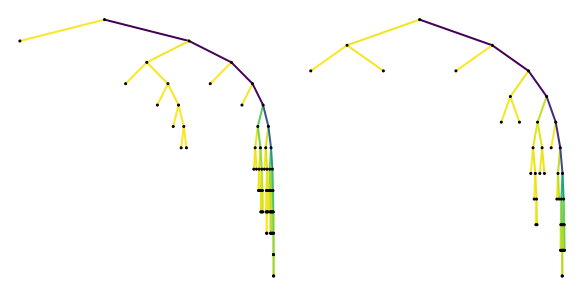

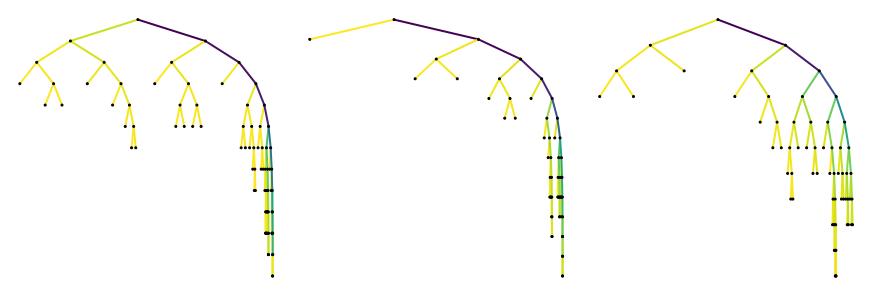

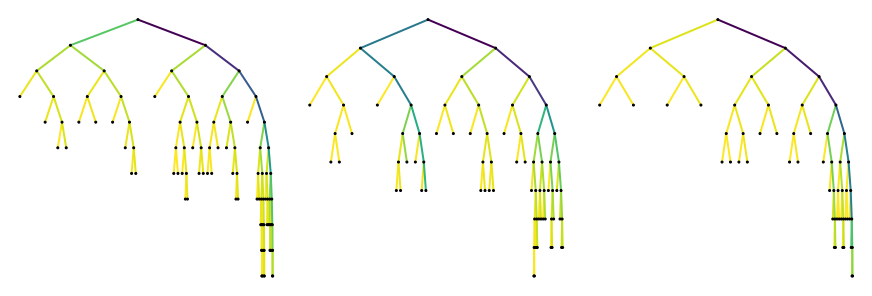

In [3]:
with get_particles(data='events_1.hepmc', stop=3) as event:
        
    for particles in event:
        sequence=cluster(particles, R=1., p=-1, ep=True)
        jets=sequence.inclusive_jets(ptmin=20.0)            

        trees=[]
        for jet in jets:

            tree=decluster(jet)                 
            trees.append(tree)
            
        draw_trees(trees)

Optionally, jet trees can also be directed graphs:

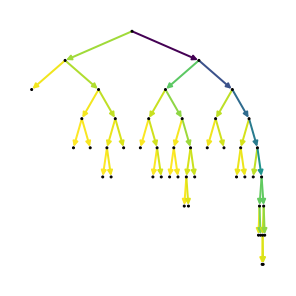

In [10]:
tree=decluster(jet, directed=True)  
draw_trees([tree])

# Jet adjacency matrix:

All ```Networkx``` functionalities can be used for the jet trees. For example, like extracting the graph adjacency matrix:

In [12]:
M_adj=nx.to_numpy_array(tree,weight=None)
pd.DataFrame(M_adj)

,0,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,45,46
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Adding features to nodes:

One can specify function as arguments for ```decluster``` in order to compute any desired observales during at each dclusetring stage. These observables are computed and stored in each tree node as a node callable 'feature'. In a similar whay, node labels can also stored.

Notice that the features have to be functions of three argument pseudojets ```(j,ja,jb)``` in this order (first the mother subjet, followed by the hardest then soft daughter subjets) 


In [4]:
# add features and labels to each node:

# feature example:

def z(j,ja,jb): 
    # j -> ja jb  with pt(ja) > pt(jb)
    return round(jb.pt/(ja.pt+jb.pt),3)

# label example:

def get_particle_id(subjet): 
    # assigns particle ID to final state particles (leafs) in tree
    # this requires the Particles package for particle ID.
    if len(subjet)==1:
        return int(subjet.pid)
    else:
        return None

with get_particles(data='events_1.hepmc', stop=1, dtype='PTEPM') as event:
    for particles in event:
 
        sequence=cluster(particles, R=1., p=-1)  # cluster using anti-kt
        jets=sequence.inclusive_jets(ptmin=20.0)            
        
        for jet in jets:
            
            tree=decluster(jet, node_feature=z, node_label=get_particle_id) 
            
            if tree:

                subjets=nx.get_node_attributes(tree,'pseudojet')        
                primary=nx.get_node_attributes(tree,'primary_branch')  
                features=nx.get_node_attributes(tree,'feature')         
                labels=nx.get_node_attributes(tree,'label')              

                # extract leaf nodes, i.e. jet constituents

                print('-----------------------------------------------------------------------------------')    
                print('{:<8} {:<10} {:<10} {:<10} {}'.format('node','PDG id',' z','primary', 'subjet '))
                print('-----------------------------------------------------------------------------------')

                for n in nx.nodes(tree):
                    print( '{:<8} {:<10} {:<10} {:<10} {}'.format(str(n), str(labels[n]) , str(features[n]),str(primary[n]), subjets[n]) )                
            break
            


------------------------------------------------------------------------------------------------------
node     PDG id      z         primary    subjet 
------------------------------------------------------------------------------------------------------
1        None       0.007      True       PseudoJet(pt=29.384, eta=0.816, phi=-0.852, mass=10.094)
3        22         None       False      PseudoJet(pt=0.197, eta=-0.181, phi=-0.898, mass=0.000)
2        None       0.017      True       PseudoJet(pt=29.186, eta=0.821, phi=-0.852, mass=9.753)
5        None       0.043      False      PseudoJet(pt=0.492, eta=1.190, phi=-1.560, mass=0.492)
4        None       0.003      True       PseudoJet(pt=28.814, eta=0.811, phi=-0.841, mass=8.602)
9        22         None       False      PseudoJet(pt=0.079, eta=1.434, phi=-1.081, mass=0.000)
8        None       0.011      True       PseudoJet(pt=28.738, eta=0.809, phi=-0.840, mass=8.522)
17       22         None       False      PseudoJet(pt=0.32